# Import Libraries

In [ ]:
!pip install ogb
!pip install DGL
!pip install torch-scatter -q -f https://pytorch-geometric.com/whl/torch-1.10.0+cu111.html
!pip install torch-sparse -q -f https://pytorch-geometric.com/whl/torch-1.10.0+cu111.html
!pip install torch-cluster -q -f https://pytorch-geometric.com/whl/torch-1.10.0+cu111.html
!pip install torch-spline-conv -q -f https://pytorch-geometric.com/whl/torch-1.10.0+cu111.html
!pip install torch-geometric

     |████████████████████████████████| 78 kB 3.8 MB/s 
  Created wheel for littleutils: filename=littleutils-0.2.2-py3-none-any.whl size=7048 sha256=02220b2e5e962df6576bfc178eac8ed1f0ece7d22c722a04adc070937731fe80
  Stored in directory: /root/.cache/pip/wheels/d6/64/cd/32819b511a488e4993f2fab909a95330289c3f4e0f6ef4676d
Successfully built littleutils
     |████████████████████████████████| 4.4 MB 5.0 MB/s 
     |████████████████████████████████| 7.9 MB 2.8 MB/s 
     |████████████████████████████████| 3.5 MB 2.8 MB/s 
     |████████████████████████████████| 2.3 MB 2.0 MB/s 
     |████████████████████████████████| 747 kB 2.6 MB/s 
     |████████████████████████████████| 370 kB 5.2 MB/s 
     |████████████████████████████████| 482 kB 57.4 MB/s 
     |████████████████████████████████| 41 kB 745 kB/s 
  Created wheel for torch-geometric: filename=torch_geometric-2.0.3-py3-none-any.whl size=581968 sha256=2109100fd2f43082c2b71a33054549bbd32214e73ec2829bf015b39c85258c5d
  Stored in directory:

In [ ]:
from torch_geometric.nn import Node2Vec

import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader


from torch_sparse import SparseTensor
import torch_geometric.transforms as T
from torch_geometric.nn import GCNConv, SAGEConv
from torch_geometric.utils import negative_sampling

from ogb.linkproppred import PygLinkPropPredDataset, Evaluator

import networkx as nx
import matplotlib.pyplot as plt

# Data Exploration and Visualization

In [ ]:
dataset = PygLinkPropPredDataset(name='ogbl-ddi')
data = dataset[0]
print(data)
print(data.edge_index)

Downloaded 0.04 GB: 100%|██████████| 46/46 [00:05<00:00,  9.17it/s]


Extracting dataset/ddi.zip


Processing...


Loading necessary files...
This might take a while.
Processing graphs...


100%|██████████| 1/1 [00:00<00:00, 32.41it/s]


Converting graphs into PyG objects...


100%|██████████| 1/1 [00:00<00:00, 2016.49it/s]

Saving...
Data(edge_index=[2, 2135822])
tensor([[4039, 2424, 4039,  ...,  338,  835, 3554],
        [2424, 4039,  225,  ...,  708, 3554,  835]])



Done!


In [ ]:
split_edge = dataset.get_edge_split()
print(split_edge.keys())
print(split_edge['test'].keys())

dict_keys(['train', 'valid', 'test'])
dict_keys(['edge', 'edge_neg'])


In [ ]:
G = nx.Graph()

In [ ]:
a = data.edge_index.numpy().T
a.shape

(2135822, 2)

In [ ]:
b = a.reshape(-1)

In [ ]:
G.add_nodes_from(b)

In [ ]:
b = [i.item() for i in b]

In [ ]:
G.add_edges_from(a, edge_attr=True)

In [ ]:
G.number_of_nodes(), G.number_of_edges()

(4267, 1067911)

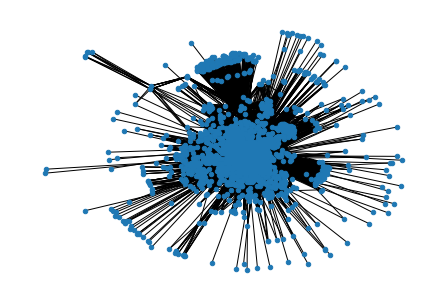

In [ ]:
import matplotlib.pyplot as plt
nx.draw(G, node_size=20, cmap='Pastel1')

# Node2Vec

In this part I generate embeddings and save them in .pt format

In [ ]:
model = Node2Vec(data.edge_index, embedding_dim=48, walk_length=20,
                  context_size=10, walks_per_node=10,
                  num_negative_samples=1, p=1, q=1, sparse=True)

In [ ]:
t = list(model.parameters())
print(t[0].shape)

torch.Size([4267, 48])


In [ ]:
loader = model.loader(batch_size=256, shuffle=True,
                          num_workers=4)
optimizer = torch.optim.SparseAdam(list(model.parameters()), lr=0.01)

model.train()
print(model.embedding)

Embedding(4267, 48, sparse=True)


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
def save_embedding(model):
    torch.save(model.embedding.weight.data.cpu(), '/content/drive/MyDrive/ML with Graph/embedding.pt')

In [ ]:
for epoch in range(1, 101):
    for i, (pos_rw, neg_rw) in enumerate(loader):
        optimizer.zero_grad()
        loss = model.loss(pos_rw, neg_rw)
        loss.backward()
        optimizer.step()

        if (i + 1) % 1 == 0:
            print(f'Epoch: {epoch:02d}, Step: {i+1:03d}/{len(loader)}, '
                  f'Loss: {loss:.4f}')

        if (i + 1) % 100 == 0:  # Save model every 100 steps.
            save_embedding(model)
    save_embedding(model)


In [ ]:
model.embedding

Embedding(4267, 48, sparse=True)

# Link Predictor Class

In [ ]:
class LinkPredictor(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, num_layers, dropout):
      super(LinkPredictor, self).__init__()

      self.lins = torch.nn.ModuleList()
      self.lins.append(torch.nn.Linear(in_channels, hidden_channels))
      for _ in range(num_layers - 2):
          self.lins.append(torch.nn.Linear(hidden_channels, hidden_channels))
      self.lins.append(torch.nn.Linear(hidden_channels, out_channels))

      self.dropout = dropout

    def reset_parameters(self):
      for lin in self.lins:
          lin.reset_parameters()

    def forward(self, x_i, x_j):
      # firstly it dot products embedding vectors for 2 nodes which have edge in between
      x = x_i * x_j
      for lin in self.lins[:-1]:
          x = lin(x)
          x = F.relu(x)
          x = F.dropout(x, p=self.dropout, training=self.training)
      x = self.lins[-1](x)
      return torch.sigmoid(x)

# MLP

## Train Function for MLP

In [ ]:
def train(predictor, x, edge_index, split_edge, optimizer, batch_size):
  predictor.train()

  pos_train_edge = split_edge['train']['edge'].to(x.device)

  total_loss = total_examples = 0
  for perm in DataLoader(range(pos_train_edge.size(0)), batch_size, shuffle=True):
    optimizer.zero_grad()

    edge = pos_train_edge[perm].t()

    pos_out = predictor(x[edge[0]], x[edge[1]])
    pos_loss = -torch.log(pos_out + 1e-15).mean()

    edge = negative_sampling(edge_index, num_nodes=x.size(0), num_neg_samples=perm.size(0), method='dense')

    neg_out = predictor(x[edge[0]], x[edge[1]])
    neg_loss = -torch.log(1 - neg_out + 1e-15).mean()

    loss = pos_loss + neg_loss
    loss.backward()
    optimizer.step()

    num_examples = pos_out.size(0)
    total_loss += loss.item() * num_examples
    total_examples += num_examples

  return total_loss / total_examples


## Test Function for MLP

In [ ]:
@torch.no_grad()
def test(predictor, x, split_edge, evaluator, batch_size):
  predictor.eval()

  pos_train_edge = split_edge['eval_train']['edge']
  pos_valid_edge = split_edge['valid']['edge']
  neg_valid_edge = split_edge['valid']['edge_neg']
  pos_test_edge = split_edge['test']['edge']
  neg_test_edge = split_edge['test']['edge_neg']

  pos_train_preds = []
  for perm in DataLoader(range(pos_train_edge.size(0)), batch_size):
      edge = pos_train_edge[perm].t()
      pos_train_preds += [predictor(x[edge[0]], x[edge[1]]).squeeze().cpu()]
  pos_train_pred = torch.cat(pos_train_preds, dim=0)

  pos_valid_preds = []
  for perm in DataLoader(range(pos_valid_edge.size(0)), batch_size):
      edge = pos_valid_edge[perm].t()
      pos_valid_preds += [predictor(x[edge[0]], x[edge[1]]).squeeze().cpu()]
  pos_valid_pred = torch.cat(pos_valid_preds, dim=0)

  neg_valid_preds = []
  for perm in DataLoader(range(neg_valid_edge.size(0)), batch_size):
      edge = neg_valid_edge[perm].t()
      neg_valid_preds += [predictor(x[edge[0]], x[edge[1]]).squeeze().cpu()]
  neg_valid_pred = torch.cat(neg_valid_preds, dim=0)

  pos_test_preds = []
  for perm in DataLoader(range(pos_test_edge.size(0)), batch_size):
      edge = pos_test_edge[perm].t()
      pos_test_preds += [predictor(x[edge[0]], x[edge[1]]).squeeze().cpu()]
  pos_test_pred = torch.cat(pos_test_preds, dim=0)

  neg_test_preds = []
  for perm in DataLoader(range(neg_test_edge.size(0)), batch_size):
      edge = neg_test_edge[perm].t()
      neg_test_preds += [predictor(x[edge[0]], x[edge[1]]).squeeze().cpu()]
  neg_test_pred = torch.cat(neg_test_preds, dim=0)

  results = {}
  # for K in [10, 20, 30]:
  K=20
  evaluator.K = K
  train_hits = evaluator.eval({
      'y_pred_pos': pos_train_pred,
      'y_pred_neg': neg_valid_pred,
  })[f'hits@{K}']
  valid_hits = evaluator.eval({
      'y_pred_pos': pos_valid_pred,
      'y_pred_neg': neg_valid_pred,
  })[f'hits@{K}']
  test_hits = evaluator.eval({
      'y_pred_pos': pos_test_pred,
      'y_pred_neg': neg_test_pred,
  })[f'hits@{K}']

  results[f'Hits@{K}'] = (train_hits, valid_hits, test_hits)

  return results

# GCN

## GCN Class

In [ ]:
class GCN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, num_layers,
                 dropout):
        super(GCN, self).__init__()

        self.convs = torch.nn.ModuleList()
        self.convs.append(GCNConv(in_channels, hidden_channels, cached=True))
        for _ in range(num_layers - 2):
            self.convs.append(
                GCNConv(hidden_channels, hidden_channels, cached=True))
        self.convs.append(GCNConv(hidden_channels, out_channels, cached=True))

        self.dropout = dropout

    def reset_parameters(self):
        for conv in self.convs:
            conv.reset_parameters()

    def forward(self, x, adj_t):
        for conv in self.convs[:-1]:
            x = conv(x, adj_t)
            x = F.relu(x)
            x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.convs[-1](x, adj_t)
        return x

## Train Function for GCN

In [ ]:
def train(model, predictor, x, adj_t, split_edge, optimizer, batch_size):

    row, col, _ = adj_t.coo()
    edge_index = torch.stack([col, row], dim=0)

    model.train()
    predictor.train()

    pos_train_edge = split_edge['train']['edge'].to(x.device)

    total_loss = total_examples = 0
    for perm in DataLoader(range(pos_train_edge.size(0)), batch_size,
                           shuffle=True):
        optimizer.zero_grad()

        h = model(x, adj_t)
        ## h is the embeddings generated from GNN

        edge = pos_train_edge[perm].t()

        pos_out = predictor(h[edge[0]], h[edge[1]])
        pos_loss = -torch.log(pos_out + 1e-15).mean()

        edge = negative_sampling(edge_index, num_nodes=x.size(0),
                                 num_neg_samples=perm.size(0), method='dense')

        neg_out = predictor(h[edge[0]], h[edge[1]])
        neg_loss = -torch.log(1 - neg_out + 1e-15).mean()

        loss = pos_loss + neg_loss
        loss.backward()

        torch.nn.utils.clip_grad_norm_(x, 1.0)
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        torch.nn.utils.clip_grad_norm_(predictor.parameters(), 1.0)

        optimizer.step()

        num_examples = pos_out.size(0)
        total_loss += loss.item() * num_examples
        total_examples += num_examples

    return total_loss / total_examples


## Test Function for GCN

In [ ]:
@torch.no_grad()
def test(model, predictor, x, adj_t, split_edge, evaluator, batch_size):
    model.eval()
    predictor.eval()

    h = model(x, adj_t)

    pos_train_edge = split_edge['eval_train']['edge']
    pos_valid_edge = split_edge['valid']['edge']
    neg_valid_edge = split_edge['valid']['edge_neg']
    pos_test_edge = split_edge['test']['edge']
    neg_test_edge = split_edge['test']['edge_neg']

    pos_train_preds = []
    for perm in DataLoader(range(pos_train_edge.size(0)), batch_size):
        edge = pos_train_edge[perm].t()
        pos_train_preds += [predictor(h[edge[0]], h[edge[1]]).squeeze()]
    pos_train_pred = torch.cat(pos_train_preds, dim=0)

    pos_valid_preds = []
    for perm in DataLoader(range(pos_valid_edge.size(0)), batch_size):
        edge = pos_valid_edge[perm].t()
        pos_valid_preds += [predictor(h[edge[0]], h[edge[1]]).squeeze()]
    pos_valid_pred = torch.cat(pos_valid_preds, dim=0)

    neg_valid_preds = []
    for perm in DataLoader(range(neg_valid_edge.size(0)), batch_size):
        edge = neg_valid_edge[perm].t()
        neg_valid_preds += [predictor(h[edge[0]], h[edge[1]]).squeeze()]
    neg_valid_pred = torch.cat(neg_valid_preds, dim=0)

    pos_test_preds = []
    for perm in DataLoader(range(pos_test_edge.size(0)), batch_size):
        edge = pos_test_edge[perm].t()
        pos_test_preds += [predictor(h[edge[0]], h[edge[1]]).squeeze()]
    pos_test_pred = torch.cat(pos_test_preds, dim=0)

    neg_test_preds = []
    for perm in DataLoader(range(neg_test_edge.size(0)), batch_size):
        edge = neg_test_edge[perm].t()
        neg_test_preds += [predictor(h[edge[0]], h[edge[1]]).squeeze()]
    neg_test_pred = torch.cat(neg_test_preds, dim=0)

    results = {}
    # for K in [10, 20, 30]:
    K=20
    evaluator.K = K
    train_hits = evaluator.eval({
        'y_pred_pos': pos_train_pred,
        'y_pred_neg': neg_valid_pred,
    })[f'hits@{K}']
    valid_hits = evaluator.eval({
        'y_pred_pos': pos_valid_pred,
        'y_pred_neg': neg_valid_pred,
    })[f'hits@{K}']
    test_hits = evaluator.eval({
        'y_pred_pos': pos_test_pred,
        'y_pred_neg': neg_test_pred,
    })[f'hits@{K}']

    results[f'Hits@{K}'] = (train_hits, valid_hits, test_hits)

    return results

# Logger Class

In [ ]:
class Logger(object):
    def __init__(self, runs, info=None):
        self.info = info
        self.results = [[] for _ in range(runs)]

    def add_result(self, run, result):
        assert len(result) == 3
        assert run >= 0 and run < len(self.results)
        self.results[run].append(result)

    def print_statistics(self, run=None):
        if run is not None:
            result = 100 * torch.tensor(self.results[run])
            argmax = result[:, 1].argmax().item()
            # print(f'Run {run + 1:02d}:')
            print(f'Highest Train: {result[:, 0].max():.2f}')
            print(f'Highest Valid: {result[:, 1].max():.2f}')
            print(f'Final Train: {result[argmax, 0]:.2f}')
            print(f'Final Test: {result[argmax, 2]:.2f}')
        else:
            result = 100 * torch.tensor(self.results)

            best_results = []
            for r in result:
                train1 = r[:, 0].max().item()
                valid = r[:, 1].max().item()
                train2 = r[r[:, 1].argmax(), 0].item()
                test = r[r[:, 1].argmax(), 2].item()
                best_results.append((train1, valid, train2, test))

            best_result = torch.tensor(best_results)

            print(f'All runs:')
            r = best_result[:, 0]
            print(f'Highest Train: {r.mean():.2f} ± {r.std():.2f}')
            r = best_result[:, 1]
            print(f'Highest Valid: {r.mean():.2f} ± {r.std():.2f}')
            r = best_result[:, 2]
            print(f'  Final Train: {r.mean():.2f} ± {r.std():.2f}')
            r = best_result[:, 3]
            print(f'   Final Test: {r.mean():.2f} ± {r.std():.2f}')

# Main Part

## Arguments

In [ ]:
args = {
    'log_steps' : 1,
    'use_gcn': False, 
    'num_layers': 3,
    'hidden_channels': 256,
    'dropout': 0.5,
    'batch_size': 64*1024,
    'eval_steps': 1,
    'lr': 0.01,
    'epochs': 100,
    'runs' : 1
}
args

{'batch_size': 65536,
 'dropout': 0.5,
 'epochs': 100,
 'eval_steps': 1,
 'hidden_channels': 256,
 'log_steps': 1,
 'lr': 0.01,
 'num_layers': 3,
 'runs': 1,
 'use_gcn': False}

## Select Model

In [ ]:

if args['use_gcn']:
  dataset = PygLinkPropPredDataset(name='ogbl-ddi', transform=T.ToSparseTensor())
  data = dataset[0]
  adj_t = data.adj_t
  split_edge = dataset.get_edge_split()
  
  torch.manual_seed(12345)
  idx = torch.randperm(split_edge['train']['edge'].size(0))
  idx = idx[:split_edge['valid']['edge'].size(0)]
  split_edge['eval_train'] = {'edge': split_edge['train']['edge'][idx]}

  model = GCN(args['hidden_channels'], args['hidden_channels'], args['hidden_channels'], args['num_layers'], args['dropout'])
  emb = torch.nn.Embedding(data.adj_t.size(0), args['hidden_channels'])
  predictor = LinkPredictor(args['hidden_channels'], args['hidden_channels'], 1, args['num_layers'], args['dropout'])

else:
  dataset = PygLinkPropPredDataset(name='ogbl-ddi')
  data = dataset[0]
  split_edge = dataset.get_edge_split()

  torch.manual_seed(12345)
  idx = torch.randperm(split_edge['train']['edge'].size(0))
  idx = idx[:split_edge['valid']['edge'].size(0)]
  split_edge['eval_train'] = {'edge': split_edge['train']['edge'][idx]}

  x = torch.load('/content/drive/MyDrive/ML with Graph/embedding.pt')
  predictor = LinkPredictor(x.size(-1), args['hidden_channels'], 1, args['num_layers'], args['dropout'])


evaluator = Evaluator(name='ogbl-ddi')
loggers = {'Hits@20': Logger(args['runs'])} #because Hits@20 is the best choice

## Training

Hits@20
Epoch: 01, Loss: 1.3512, Train: 0.02%, Valid: 0.02%, Test: 0.03%
---
Hits@20
Epoch: 02, Loss: 0.9332, Train: 6.37%, Valid: 5.93%, Test: 3.68%
---
Hits@20
Epoch: 03, Loss: 0.8113, Train: 3.88%, Valid: 3.38%, Test: 2.53%
---
Hits@20
Epoch: 04, Loss: 0.7552, Train: 4.69%, Valid: 4.35%, Test: 1.45%
---
Hits@20
Epoch: 05, Loss: 0.6742, Train: 5.66%, Valid: 5.26%, Test: 1.76%
---
Hits@20
Epoch: 06, Loss: 0.6346, Train: 17.59%, Valid: 15.94%, Test: 8.90%
---
Hits@20
Epoch: 07, Loss: 0.6169, Train: 15.39%, Valid: 13.83%, Test: 4.28%
---
Hits@20
Epoch: 08, Loss: 0.5999, Train: 18.87%, Valid: 17.04%, Test: 15.54%
---
Hits@20
Epoch: 09, Loss: 0.5882, Train: 19.14%, Valid: 17.17%, Test: 16.68%
---
Hits@20
Epoch: 10, Loss: 0.5733, Train: 15.18%, Valid: 13.74%, Test: 13.07%
---
Hits@20
Epoch: 11, Loss: 0.5539, Train: 17.98%, Valid: 16.26%, Test: 16.94%
---
Hits@20
Epoch: 12, Loss: 0.5514, Train: 29.27%, Valid: 26.78%, Test: 15.88%
---
Hits@20
Epoch: 13, Loss: 0.5168, Train: 25.18%, Valid: 23

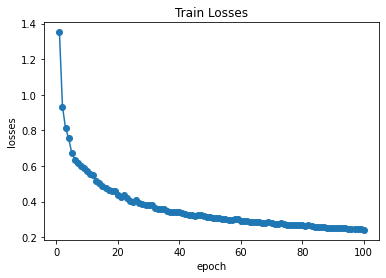

In [ ]:
train_losses = []
train_hit_20 = []
val_hit_20 = []
epoch_ls = []

for run in range(args['runs']):
  ## Train GCN
  if args['use_gcn']:
    torch.nn.init.xavier_uniform_(emb.weight)
    model.reset_parameters()
    predictor.reset_parameters()
    optimizer = torch.optim.Adam(list(model.parameters()) + list(emb.parameters()) + list(predictor.parameters()), lr=args['lr'])

    for epoch in range(1, 1 + args['epochs']):
      loss = train(model, predictor, emb.weight, adj_t, split_edge, optimizer, args['batch_size'])

      if epoch % args['eval_steps'] == 0:
        results = test(model, predictor, emb.weight, adj_t, split_edge, evaluator, args['batch_size'])
        for key, result in results.items():
            loggers[key].add_result(run, result)

        if epoch % args['log_steps'] == 0:
            for key, result in results.items():
                train_hits, valid_hits, test_hits = result
                print(key)
                print(f'Epoch: {epoch:02d}, '
                      f'Loss: {loss:.4f}, '
                      f'Train: {100 * train_hits:.2f}%, '
                      f'Valid: {100 * valid_hits:.2f}%, '
                      f'Test: {100 * test_hits:.2f}%')
            print('---')
        train_losses.append(loss)
        train_hit_20.append(train_hits)
        val_hit_20.append(valid_hits)
        epoch_ls.append(epoch)

  ### Train MLP
  else:
    predictor.reset_parameters()
    optimizer = torch.optim.Adam(predictor.parameters(), lr=args.lr)

    for epoch in range(1, 1 + args['epochs']):
      loss = train(predictor, x, data.edge_index, split_edge, optimizer, args['batch_size'])

      if epoch % args['eval_steps'] == 0:
        results = test(predictor, x, split_edge, evaluator, args.batch_size)
        for key, result in results.items():
          loggers[key].add_result(run, result)

        if epoch % args['log_steps'] == 0:
          for key, result in results.items():
              train_hits, valid_hits, test_hits = result
              print(key)
              print(f'Epoch: {epoch:02d}, '
                    f'Loss: {loss:.4f}, '
                    f'Train: {100 * train_hits:.2f}%, '
                    f'Valid: {100 * valid_hits:.2f}%, '
                    f'Test: {100 * test_hits:.2f}%')
          print('---')


  for key in loggers.keys():
    print(key)
    loggers[key].print_statistics(run)

############################ Plotting ################################

plt.plot(epoch_ls, train_losses, '-o')
plt.xlabel('epoch')
plt.ylabel('losses')
plt.title('Train Losses')
 
plt.show()

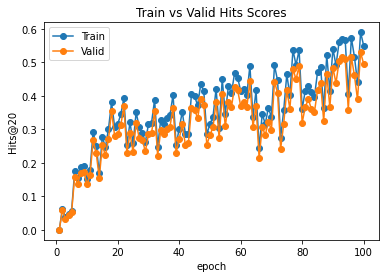

In [ ]:
plt.plot(epoch_ls, train_hit_20, '-o')
plt.plot(epoch_ls, val_hit_20, '-o')
plt.xlabel('epoch')
plt.ylabel('Hits@20')
plt.legend(['Train','Valid'])
plt.title('Train vs Valid Hits Scores')

plt.show()

Hits@20
Epoch: 01, Loss: 1.0489, Train: 0.44%, Valid: 0.42%, Test: 0.26%
---
Hits@20
Epoch: 02, Loss: 0.9301, Train: 0.69%, Valid: 0.64%, Test: 0.35%
---
Hits@20
Epoch: 03, Loss: 0.9136, Train: 1.03%, Valid: 0.94%, Test: 0.46%
---
Hits@20
Epoch: 04, Loss: 0.9068, Train: 1.05%, Valid: 0.94%, Test: 0.62%
---
Hits@20
Epoch: 05, Loss: 0.9015, Train: 1.06%, Valid: 0.95%, Test: 0.60%
---
Hits@20
Epoch: 06, Loss: 0.8982, Train: 1.17%, Valid: 1.04%, Test: 0.61%
---
Hits@20
Epoch: 07, Loss: 0.8965, Train: 1.23%, Valid: 1.08%, Test: 0.55%
---
Hits@20
Epoch: 08, Loss: 0.8933, Train: 1.27%, Valid: 1.12%, Test: 0.65%
---
Hits@20
Epoch: 09, Loss: 0.8939, Train: 1.66%, Valid: 1.48%, Test: 0.63%
---
Hits@20
Epoch: 10, Loss: 0.8917, Train: 1.69%, Valid: 1.52%, Test: 0.86%
---
Hits@20
Epoch: 11, Loss: 0.8914, Train: 1.79%, Valid: 1.58%, Test: 0.91%
---
Hits@20
Epoch: 12, Loss: 0.8892, Train: 2.17%, Valid: 1.96%, Test: 1.01%
---
Hits@20
Epoch: 13, Loss: 0.8891, Train: 2.33%, Valid: 2.10%, Test: 1.12%
---

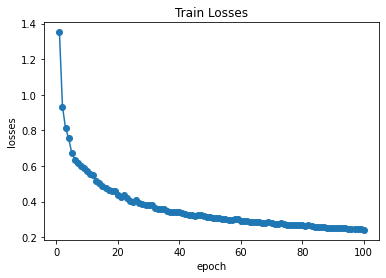

In [ ]:
### MLP
train_losses_M = []
train_hit_20_M = []
val_hit_20_M = []
epoch_ls_M = []

for run in range(args['runs']):
  ## Train GCN
  if args['use_gcn']:
    torch.nn.init.xavier_uniform_(emb.weight)
    model.reset_parameters()
    predictor.reset_parameters()
    optimizer = torch.optim.Adam(list(model.parameters()) + list(emb.parameters()) + list(predictor.parameters()), lr=args['lr'])

    for epoch in range(1, 1 + args['epochs']):
      loss = train(model, predictor, emb.weight, adj_t, split_edge, optimizer, args['batch_size'])

      if epoch % args['eval_steps'] == 0:
        results = test(model, predictor, emb.weight, adj_t, split_edge, evaluator, args['batch_size'])
        for key, result in results.items():
            loggers[key].add_result(run, result)

        if epoch % args['log_steps'] == 0:
            for key, result in results.items():
                train_hits, valid_hits, test_hits = result
                print(key)
                print(f'Epoch: {epoch:02d}, '
                      f'Loss: {loss:.4f}, '
                      f'Train: {100 * train_hits:.2f}%, '
                      f'Valid: {100 * valid_hits:.2f}%, '
                      f'Test: {100 * test_hits:.2f}%')
            print('---')
        train_losses.append(loss)
        train_hit_20.append(train_hits)
        val_hit_20.append(valid_hits)
        epoch_ls.append(epoch)

  ### Train MLP
  else:
    predictor.reset_parameters()
    optimizer = torch.optim.Adam(predictor.parameters(), lr=args['lr'])

    for epoch in range(1, 1 + args['epochs']):
      loss = train(predictor, x, data.edge_index, split_edge, optimizer, args['batch_size'])

      if epoch % args['eval_steps'] == 0:
        results = test(predictor, x, split_edge, evaluator, args['batch_size'])
        for key, result in results.items():
          loggers[key].add_result(run, result)

        if epoch % args['log_steps'] == 0:
          for key, result in results.items():
            train_hits, valid_hits, test_hits = result
            print(key)
            print(f'Epoch: {epoch:02d}, '
                  f'Loss: {loss:.4f}, '
                  f'Train: {100 * train_hits:.2f}%, '
                  f'Valid: {100 * valid_hits:.2f}%, '
                  f'Test: {100 * test_hits:.2f}%')
          print('---')
        train_losses_M.append(loss)
        train_hit_20_M.append(train_hits)
        val_hit_20_M.append(valid_hits)
        epoch_ls_M.append(epoch)


  for key in loggers.keys():
    print(key)
    loggers[key].print_statistics(run)

############################ Plotting ################################

plt.plot(epoch_ls, train_losses, '-o')
plt.xlabel('epoch')
plt.ylabel('losses')
plt.title('Train Losses')
 
plt.show()

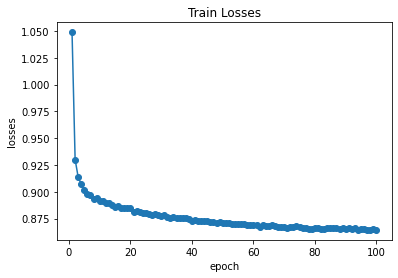

In [ ]:
plt.plot(epoch_ls_M, train_losses_M, '-o')
plt.xlabel('epoch')
plt.ylabel('losses')
plt.title('Train Losses')
 
plt.show()

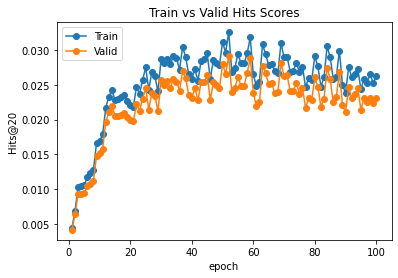

In [ ]:
plt.plot(epoch_ls_M, train_hit_20_M, '-o')
plt.plot(epoch_ls_M, val_hit_20_M, '-o')
plt.xlabel('epoch')
plt.ylabel('Hits@20')
plt.legend(['Train','Valid'])
plt.title('Train vs Valid Hits Scores')

plt.show()